# Imports

In [1]:

import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf

from zipfile import ZipFile
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import TensorBoard


In [2]:
if os.path.exists('./model.h5'):
    model = tf.keras.models.load_model('./model.h5')

if os.path.exists('./model_enhanced.h5'):
    model_enhanced = tf.keras.models.load_model('./model_enhanced.h5')


Metal device set to: AMD Radeon Pro 5500M

systemMemory: 32.00 GB
maxCacheSize: 3.99 GB



2022-12-29 14:04:21.643538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-29 14:04:21.643910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Dataset Download

In [2]:
# download the dataset
# make sure you have your kaggle api key on the system
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


# Data Preparation

In [2]:
# define some files and dirs
home_dir = os.path.expanduser('.')
dvc_zip = os.path.expanduser('./dogs-vs-cats.zip')

test1_zip = os.path.expanduser('./test1.zip')
train_zip = os.path.expanduser('./train.zip')

test1 = os.path.expanduser('./test1')
train = os.path.expanduser('./train')

In [3]:
# unzip the files
if not (os.path.exists(test1_zip) and os.path.exists(train_zip)):
    with ZipFile(dvc_zip) as z:
        z.extractall(path=home_dir)

if not os.path.exists(test1):
    with ZipFile(test1_zip) as z:
        z.extractall(path=home_dir)
        
if not os.path.exists(train):
    with ZipFile(train_zip) as z:
        z.extractall(path=home_dir)

## Training Data

In [4]:
# create a list for the full dataset
x_list = list()
y_list = list()

for f in os.listdir(train):
    if f.startswith('dog'):
        y_list.append([1])
    elif f.startswith('cat'):
        y_list.append([0])
    
    # load image file and set their size to 128 * 128
    img_file = train + '/' + f
    img = cv2.resize(cv2.imread(img_file), (128, 128))
    
    x_list.append(img)

# convert train list to array
x_full_ds = np.array(x_list, dtype='float16')
y_full_ds = np.array(y_list, dtype='float16')

# delete the lists
del x_list
del y_list

print(x_full_ds.shape)
print(y_full_ds.shape)


(25000, 128, 128, 3)
(25000, 1)


In [5]:
# convert train labels to categorical arrays
y_full_ds = to_categorical(y_full_ds)

y_full_ds

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [6]:
# normalize training data
x_full_ds = x_full_ds / 255.0
x_full_ds


array([[[[0.1804  , 0.1333  , 0.0941  ],
         [0.2157  , 0.1412  , 0.0902  ],
         [0.2942  , 0.204   , 0.1412  ],
         ...,
         [0.863   , 0.706   , 0.608   ],
         [0.9214  , 0.7607  , 0.6626  ],
         [0.9136  , 0.749   , 0.643   ]],

        [[0.1608  , 0.1137  , 0.0706  ],
         [0.204   , 0.1294  , 0.0784  ],
         [0.2627  , 0.1726  , 0.1098  ],
         ...,
         [0.8745  , 0.714   , 0.612   ],
         [0.8706  , 0.71    , 0.608   ],
         [0.9097  , 0.749   , 0.651   ]],

        [[0.149   , 0.102   , 0.06274 ],
         [0.1921  , 0.1177  , 0.06665 ],
         [0.2666  , 0.1765  , 0.1137  ],
         ...,
         [0.8237  , 0.651   , 0.537   ],
         [0.851   , 0.6943  , 0.5845  ],
         [0.9136  , 0.757   , 0.6665  ]],

        ...,

        [[0.251   , 0.1412  , 0.1098  ],
         [0.2079  , 0.1177  , 0.08234 ],
         [0.1647  , 0.102   , 0.0549  ],
         ...,
         [0.3215  , 0.2196  , 0.1569  ],
         [0.3254  , 0.

## Prediction Data

In [7]:
# create a list for the full dataset
x_pred_list = list()

for f in os.listdir(test1):
    # load image file and set their size to 128 * 128
    img_file = test1 + '/' + f
    img = cv2.resize(cv2.imread(img_file), (128, 128))
    
    x_pred_list.append(img)

# convert train list to array
x_pred_ds = np.array(x_pred_list, dtype='float16')

# delete the prediction list
del x_pred_list

print(x_pred_ds.shape)

# normalize data
x_pred_ds = x_pred_ds / 255.0

(12500, 128, 128, 3)


## Split Train, Validate, and Test Data

We will split the data into three datasets:
1. Train dataset (x_train, y_train)
2. Validation dataset (x_val, y_val)
3. Test dataset (x_test, y_test)

The test dataset will be used to evaluate the models at the end of its training.

In [8]:
# split the full dataset to train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_full_ds, y_full_ds, test_size=0.2, random_state=0)

# split the validation dataset to validation and test
x_val, x_test, y_val, y_test = train_test_split(
    x_val, y_val, test_size=0.5, random_state=0)

# delete the full datasets - conserve memory
del x_full_ds
del y_full_ds

# CNN Models

## Baseline model

In [10]:
%load_ext tensorboard

# create folders
# now = datetime.now().strftime('%Y%m%d%H%M')
log_folder = f'Tensorboard Logs/Baseline Model'

# callbacks for TensorBoard
callbacks = TensorBoard(log_dir=log_folder, histogram_freq=1)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
        kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation='relu',
        kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()


2022-12-29 14:11:25.516204: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-29 14:11:25.516531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 5500M

systemMemory: 32.00 GB
maxCacheSize: 3.99 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (Non

In [11]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1)


Epoch 1/20


2022-12-29 14:11:32.587254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 1.1596 - accuracy: 0.6423

2022-12-29 14:12:16.870074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 50s 77ms/step - loss: 1.1596 - accuracy: 0.6423 - val_loss: 0.5457 - val_accuracy: 0.7192
Epoch 2/20
625/625 [==============================] - 48s 77ms/step - loss: 0.4823 - accuracy: 0.7687 - val_loss: 0.5041 - val_accuracy: 0.7572
Epoch 3/20
625/625 [==============================] - 49s 78ms/step - loss: 0.3187 - accuracy: 0.8647 - val_loss: 0.5857 - val_accuracy: 0.7500
Epoch 4/20
625/625 [==============================] - 47s 75ms/step - loss: 0.1483 - accuracy: 0.9433 - val_loss: 0.8355 - val_accuracy: 0.7392
Epoch 5/20
625/625 [==============================] - 48s 77ms/step - loss: 0.0656 - accuracy: 0.9778 - val_loss: 1.1151 - val_accuracy: 0.7408
Epoch 6/20
625/625 [==============================] - 47s 75ms/step - loss: 0.0374 - accuracy: 0.9886 - val_loss: 1.2130 - val_accuracy: 0.7372
Epoch 7/20
625/625 [==============================] - 46s 73ms/step - loss: 0.0230 - accuracy: 0.9929 - val_loss: 1.3923 - val_accuracy: 0.7452
Epo

In [12]:
# evaluate the model accuracy
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print(' Model accuracy: {:5.2f}%'.format(100 * acc))


79/79 [==============================] - 3s 37ms/step - loss: 2.2230 - accuracy: 0.7604
 Model accuracy: 76.04%


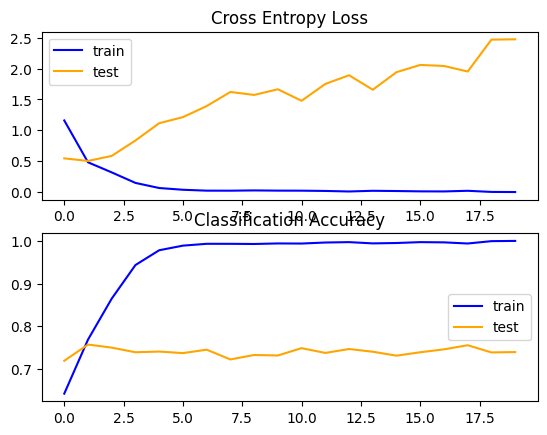

In [13]:
# plot crossentropy losses
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
pyplot.legend()
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
pyplot.legend()


In [14]:
# save model
model.save('model.h5')

### Prediction

In [15]:
# predict the labels
y_pred = model.predict(x_pred_ds)

  5/391 [..............................] - ETA: 10s

2022-12-29 14:26:33.495980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 12s 30ms/step


In [16]:
y_pred.shape

(12500, 2)

In [17]:
# create a dataframe with two columns, test image filename and prediction label
df = pd.DataFrame()
filename = []
label = []
for i in zip(os.listdir(test1), y_pred):
    filename.append(i[0])
    label.append('Dog' if i[1][1] > i[1][0] else 'Cat')

df['Filename'] = filename
df['Label'] = label

df.head()

df.to_csv('model_predictions.csv')

## Enhanced Model

In [18]:
%load_ext tensorboard

# create folders
# now = datetime.now().strftime('%Y%m%d%H%M')
log_folder = f'Tensorboard Logs/Enhanced Model'

# callbacks for TensorBoard
callbacks = TensorBoard(log_dir=log_folder, histogram_freq=1)

model_enhanced = Sequential()
model_enhanced.add(Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
model_enhanced.add(BatchNormalization())
model_enhanced.add(Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(MaxPooling2D((2, 2)))
model_enhanced.add(Dropout(0.2))
model_enhanced.add(Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(MaxPooling2D((2, 2)))
model_enhanced.add(Dropout(0.3))
model_enhanced.add(Conv2D(128, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(Conv2D(128, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(MaxPooling2D((2, 2)))
model_enhanced.add(Dropout(0.4))
model_enhanced.add(Flatten())
model_enhanced.add(Dense(128, activation='relu',
                    kernel_initializer='he_uniform'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(Dropout(0.5))
model_enhanced.add(Dense(2, activation='softmax'))

# compile model
model_enhanced.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [19]:
model_enhanced.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                      

In [20]:
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1)

# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=32)

In [21]:
# fit model
steps = int(x_train.shape[0] / 32)
history_enhanced = model_enhanced.fit(
    it_train,
    steps_per_epoch=steps,
    epochs=20,
    # validation_data=(it_x_test, it_y_test),
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1)

Epoch 1/20


2022-12-29 14:26:50.782103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.6449

2022-12-29 14:28:06.322842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 81s 125ms/step - loss: 0.6673 - accuracy: 0.6449 - val_loss: 0.6514 - val_accuracy: 0.6724
Epoch 2/20
625/625 [==============================] - 80s 128ms/step - loss: 0.5956 - accuracy: 0.6823 - val_loss: 0.5294 - val_accuracy: 0.7312
Epoch 3/20
625/625 [==============================] - 80s 128ms/step - loss: 0.5155 - accuracy: 0.7436 - val_loss: 0.4589 - val_accuracy: 0.7844
Epoch 4/20
625/625 [==============================] - 80s 128ms/step - loss: 0.4656 - accuracy: 0.7793 - val_loss: 0.7940 - val_accuracy: 0.6416
Epoch 5/20
625/625 [==============================] - 81s 129ms/step - loss: 0.4084 - accuracy: 0.8137 - val_loss: 0.4045 - val_accuracy: 0.8092
Epoch 6/20
625/625 [==============================] - 81s 129ms/step - loss: 0.3564 - accuracy: 0.8415 - val_loss: 0.5510 - val_accuracy: 0.7600
Epoch 7/20
625/625 [==============================] - 81s 129ms/step - loss: 0.3045 - accuracy: 0.8666 - val_loss: 0.2647 - val_accuracy: 0.8

In [22]:
# evaluate the model accuracy
loss, acc = model_enhanced.evaluate(x_test, y_test, verbose=1)
print('Model accuracy: {:5.2f}%'.format(100 * acc))


79/79 [==============================] - 3s 41ms/step - loss: 0.1297 - accuracy: 0.9508
Model accuracy: 95.08%


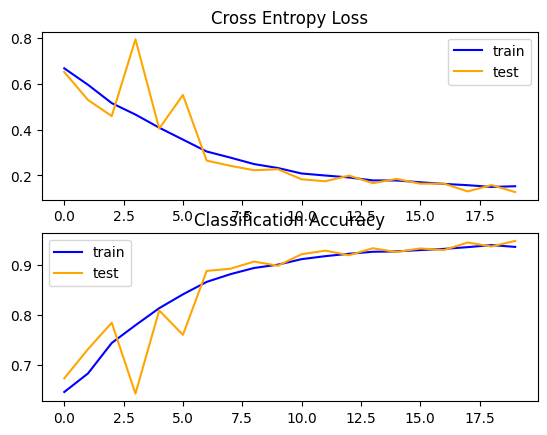

In [23]:
# plot crossentropy losses
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history_enhanced.history['loss'], color='blue', label='train')
pyplot.plot(history_enhanced.history['val_loss'], color='orange', label='test')
pyplot.legend()
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history_enhanced.history['accuracy'], color='blue', label='train')
pyplot.plot(history_enhanced.history['val_accuracy'], color='orange', label='test')
pyplot.legend()


In [24]:
model_enhanced.save('model_enhanced.h5')

### Prediction

In [25]:
# predict the labels
y_pred = model_enhanced.predict(x_pred_ds)

2022-12-29 14:54:26.478341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 14s 34ms/step


In [26]:
y_pred.shape

(12500, 2)

In [27]:
# create a dataframe with two columns, test image filename and prediction label
df = pd.DataFrame()
filename = []
label = []
for i in zip(os.listdir(test1), y_pred):
    filename.append(i[0])
    label.append('Dog' if i[1][1] > i[1][0] else 'Cat')

df['Filename'] = filename
df['Label'] = label

df.head()

df.to_csv('model_enhanced_predictions.csv')

## Transfer Learning

We will import the EfficientNetB7 model without the top layer and replace it with a Dense softmax layer that classifies our images. 

In [9]:
from tensorflow import keras
tl_model = keras.applications.EfficientNetB7(include_top=False)

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 32.00 GB
maxCacheSize: 3.99 GB



2022-12-29 17:07:29.611863: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-29 17:07:29.612162: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
tl_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

Let's add our top layers. We'll have a global average pooling layer and then a dense layer with two neurons with a softmax acitivation function. 

In [11]:
avg = keras.layers.GlobalAveragePooling2D()(tl_model.output)
output = keras.layers.Dense(2, activation="softmax")(avg)
final_model = keras.models.Model(inputs=tl_model.input, outputs=output)

Let's look at the model's weights.

In [12]:
final_model.weights

[<tf.Variable 'normalization/mean:0' shape=(3,) dtype=float32, numpy=array([0.485, 0.456, 0.406], dtype=float32)>,
 <tf.Variable 'normalization/variance:0' shape=(3,) dtype=float32, numpy=array([0.229, 0.224, 0.225], dtype=float32)>,
 <tf.Variable 'normalization/count:0' shape=() dtype=int64, numpy=0>,
 <tf.Variable 'stem_conv/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[-3.77828836e-01,  2.76361465e-01, -8.32918435e-02, ...,
           -1.77597940e-01,  1.47596002e-05,  1.39584079e-01],
          [-6.60683036e-01,  1.39902234e+00, -3.56699824e-02, ...,
           -1.40343934e-01, -5.77094033e-06,  6.66381001e-01],
          [-3.44433308e-01,  1.52912617e-01, -8.17556828e-02, ...,
           -1.24101147e-01, -2.71759927e-05,  5.86694404e-02]],
 
         [[-4.45116431e-01,  6.77551866e-01, -2.87770331e-02, ...,
           -1.19002983e-01,  1.84602104e-05,  2.16148943e-01],
          [-5.31597972e-01,  2.03446937e+00,  7.67395571e-02, ...,
           -2.53242254e-01, -

In [13]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                            

We can start training/fitting our new model now with our train and validation data, all while "freezing" the model's original weights in all the lower layers.

In [14]:
# preprocess the input data first
x_train_new = list()
x_val_new = list()
x_test_new = list()

for img in x_train:
    x_train_new.append(keras.applications.efficientnet.preprocess_input(img))
for img in x_val:
    x_val_new.append(keras.applications.efficientnet.preprocess_input(img))
for img in x_test:
    x_test_new.append(keras.applications.efficientnet.preprocess_input(img))

# convert lists to arrays
x_train_new = np.array(x_train_new, dtype='float16')
x_val_new = np.array(x_val_new, dtype='float16')
x_test_new = np.array(x_test_new, dtype='float16')

print(x_train_new.shape)
print(x_val_new.shape)
print(x_test_new.shape)

(20000, 128, 128, 3)
(2500, 128, 128, 3)
(2500, 128, 128, 3)


In [15]:
%load_ext tensorboard
%reload_ext tensorboard

# create folders
# now = datetime.now().strftime('%Y%m%d%H%M')
log_folder = f'Tensorboard Logs/Transfer Learning Model'

# callbacks for TensorBoard
callbacks = TensorBoard(log_dir=log_folder, histogram_freq=1)

# freeze the model weights (now, only the weights of the global avgpooling layer and the following dense layer will be updated while training)
for layer in tl_model.layers:
    layer.trainable = False

# we use a larger learning rate and a small number of epochs to get those weights converged quickly
optimizer = keras.optimizers.Adam(learning_rate=0.2, decay=0.01)
loss = keras.losses.CategoricalCrossentropy()

final_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"])

history = final_model.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1)

Epoch 1/5


2022-12-29 17:08:07.394373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 17.2320 - accuracy: 0.4997

2022-12-29 17:11:46.181892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 302s 876ms/step - loss: 17.2320 - accuracy: 0.4997 - val_loss: 22.0129 - val_accuracy: 0.4808
Epoch 2/5
313/313 [==============================] - 332s 1s/step - loss: 5.6821 - accuracy: 0.5113 - val_loss: 1.0023 - val_accuracy: 0.5240
Epoch 3/5
313/313 [==============================] - 394s 1s/step - loss: 1.5174 - accuracy: 0.5283 - val_loss: 0.9206 - val_accuracy: 0.5212
Epoch 4/5
313/313 [==============================] - 492s 2s/step - loss: 1.0769 - accuracy: 0.5375 - val_loss: 1.4275 - val_accuracy: 0.5192
Epoch 5/5
313/313 [==============================] - 569s 2s/step - loss: 0.9295 - accuracy: 0.5405 - val_loss: 2.1338 - val_accuracy: 0.5192


In [16]:
# evaluate the model accuracy
loss, acc = final_model.evaluate(x_test, y_test, verbose=1)
print('Model accuracy: {:5.2f}%'.format(100 * acc))


79/79 [==============================] - 124s 1s/step - loss: 2.2391 - accuracy: 0.4952
Model accuracy: 49.52%
